The goal of this project is to predict Fire 911 calls for the next 24 hours, accompanied by a (visual) confidence interval for the prediction.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn.linear_model
import sklearn.metrics
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller

# from sodapy import Socrata

%matplotlib inline

In [3]:
calls_data = pd.read_csv('Seattle_Real_Time_Fire_911_Calls.csv')

In [4]:
print(calls_data.info())
calls_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432560 entries, 0 to 1432559
Data columns (total 7 columns):
Address            1432528 non-null object
Type               1432560 non-null object
Datetime           1432560 non-null object
Latitude           1432326 non-null float64
Longitude          1432326 non-null float64
Report Location    1432336 non-null object
Incident Number    1432560 non-null object
dtypes: float64(2), object(5)
memory usage: 76.5+ MB
None


,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number
0,Nw 59th St / 15th Av Nw,Triaged Incident,10/11/2019 11:34:00 PM,47.671630,-122.376212,POINT (-122.376212 47.67163),F190108891
1,1431 Minor Av,Aid Response,12/27/2019 01:24:00 AM,47.613247,-122.327187,POINT (-122.327187 47.613247),F190136279
2,1402 3rd Av,Rescue Elevator,05/30/2019 11:22:00 AM,47.608766,-122.336894,POINT (-122.336894 47.608766),F190056035
3,500 17th Av,Aid Response,05/30/2019 11:23:00 AM,47.606176,-122.310249,POINT (-122.310249 47.606176),F190056036
4,201 Occidental Av S,Triaged Incident,11/12/2019 12:33:00 PM,47.600873,-122.332877,POINT (-122.332877 47.600873),F190120585


## __Clean & Prep Data__

In [5]:
calls_data.columns = map(str.lower, calls_data.columns)

calls_data = calls_data.drop(['report location', 'address'], axis=1)
calls_data = calls_data.rename(columns={'type': 'incident_category',
                                        'incident number':'id',
                                        'datetime':'timelog'}).set_index('id')
calls_data['timelog'] = pd.to_datetime(calls_data['timelog'], format='%m/%d/%Y %I:%M:%S %p')
calls_data['incident_hour'] = calls_data['timelog'].apply(lambda x: (x.year, x.month, x.day, x.hour))

calls_data.head()

,incident_category,timelog,latitude,longitude,incident_hour
id,,,,,
F190108891,Triaged Incident,2019-10-11 23:34:00,47.671630,-122.376212,"(2019, 10, 11, 23)"
F190136279,Aid Response,2019-12-27 01:24:00,47.613247,-122.327187,"(2019, 12, 27, 1)"
F190056035,Rescue Elevator,2019-05-30 11:22:00,47.608766,-122.336894,"(2019, 5, 30, 11)"
F190056036,Aid Response,2019-05-30 11:23:00,47.606176,-122.310249,"(2019, 5, 30, 11)"
F190120585,Triaged Incident,2019-11-12 12:33:00,47.600873,-122.332877,"(2019, 11, 12, 12)"


In [6]:
# Get total calls per hour
calls_grouped_hour = calls_data.groupby(['incident_hour']).size().reset_index()

calls_grouped_hour = calls_grouped_hour.rename(columns={0:'incident_count'})
calls_grouped_hour['constant'] = 1.0 # Add a constant for use with linear regression (why?)

calls_grouped_hour['incident_hour'] = calls_grouped_hour.incident_hour.apply(lambda t: datetime.datetime(year=t[0], month=t[1], day=t[2], hour=t[3]))
calls_grouped_hour.head()

,incident_hour,incident_count,constant
0,2003-11-07 09:00:00,5,1.0
1,2003-11-07 10:00:00,20,1.0
2,2003-11-07 11:00:00,5,1.0
3,2003-11-07 12:00:00,17,1.0
4,2003-11-07 13:00:00,13,1.0


C:\Users\Lofgran\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


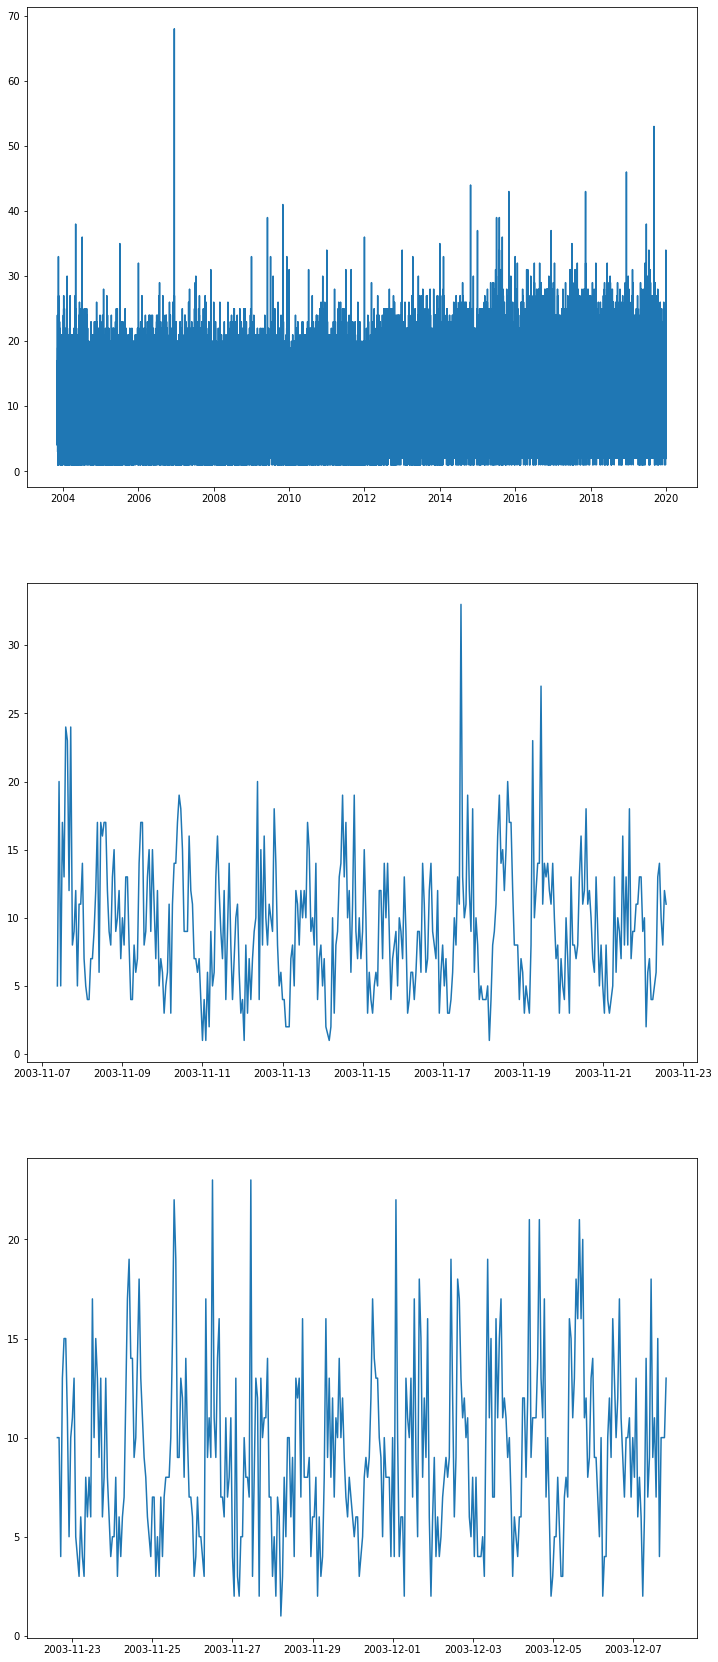

In [7]:
#Define the entire plot
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 30))

#All
ax1.plot(calls_grouped_hour.incident_hour, calls_grouped_hour.incident_count);
#Year 1
ax2.plot(calls_grouped_hour.incident_hour[:365], calls_grouped_hour.incident_count[:365]); #Seem to be peaks at regular intervals
#Year 2
ax3.plot(calls_grouped_hour.incident_hour[365:730], calls_grouped_hour.incident_count[365:730]); #Continued regularity for the 2nd year of data.  Some increase in call count. Almost always above 3 calls/day

## __Investigating Drift__

__Why:__

Drift, in general terms, is the result of data changing over time.  The reasons for the drift may vary based on a variety of changes to data influencing the predicted variable.  In machine learning, this means that the model trained on historical data is (increasingly) less accurate/applicable for the same dataset at some future date.

To fix this, features influencing potential changes can be included in the model (?).  Additionally, the model can be retrained periodically with new data so that features values are 'updated'.

In [8]:
calls_grouped_hour['incident_hour'] = calls_grouped_hour['incident_hour'].apply(lambda x: pd.to_datetime(x))

In [9]:
#Convert incident_hour data to a julian datetime format for use in regression
#Code gathered from here: https://stackoverflow.com/questions/31142181/calculating-julian-date-in-python?lq=1

def get_julian_datetime(date):
    """
    Convert a datetime object into julian float.
    Args:
        date: datetime-object of date in question

    Returns: float - Julian calculated datetime.
    Raises: 
        TypeError : Incorrect parameter type
        ValueError: Date out of range of equation
    """

    # Ensure correct format
    if not isinstance(date, datetime.datetime):
        raise TypeError('Invalid type for parameter "date" - expecting datetime')
    elif date.year < 1801 or date.year > 2099:
        raise ValueError('Datetime must be between year 1801 and 2099')

    # Perform the calculation
    julian_datetime = 367 * date.year - int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + int(
        (275 * date.month) / 9.0) + date.day + 1721013.5 + (
                          date.hour + date.minute / 60.0 + date.second / math.pow(60,
                                                                                  2)) / 24.0 - 0.5 * math.copysign(
        1, 100 * date.year + date.month - 190002.5) + 0.5

    return julian_datetime

calls_grouped_hour['julian_datetime'] = calls_grouped_hour['incident_hour'].apply(lambda x: get_julian_datetime(x))
#Verify that hours are represented properly (as decimals)
print(calls_grouped_hour.julian_datetime[1], '\n', calls_grouped_hour.julian_datetime[2])

2452950.9166666665 
 2452950.9583333335


In [10]:
#Create a partial/temporary dataframe to run the Dickey-Fuller test for the following stationarity tests
calls_grouped_hour.reset_index(inplace=True)
df_dickeyfuller = calls_grouped_hour[['incident_hour', 'incident_count']]

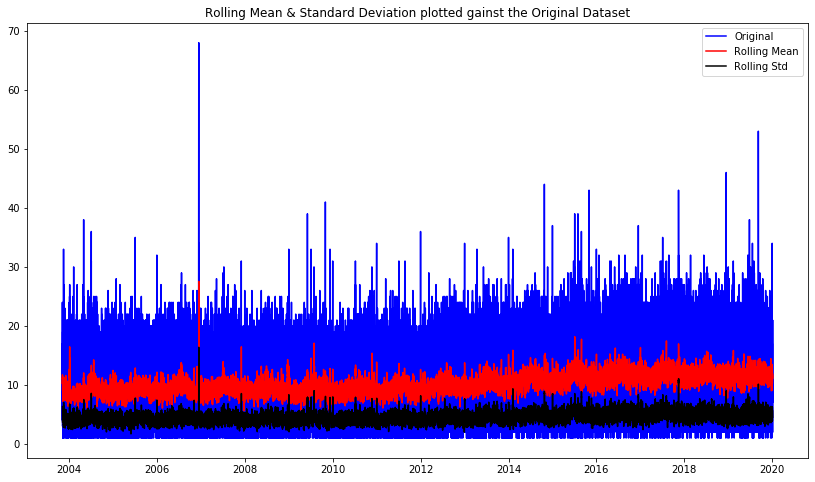

In [11]:
#Method 1: Testing for stationarity with the rolling mean and rolling standard deviation (visual)
plt.close()
#Need to set the datetime column as the index before being able to plot the following (to avoid)
df_dickeyfuller.set_index('incident_hour', inplace=True)

#Determine and plot rolling mean and standard deviation for the dataset
rolmean = df_dickeyfuller.rolling(window=24).mean()
rolstd = df_dickeyfuller.rolling(window=24).std()

plt.figure(figsize=(14, 8))

orig = plt.plot(df_dickeyfuller, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation plotted gainst the Original Dataset')
plt.show(block=False)

In [12]:
#Method 2: (Advanced?) Dickey-Fuller test is a quantitative test for determining stationarity
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_dickeyfuller['incident_count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic         -1.739074e+01
p-value                 5.011039e-30
# Lags Used             7.300000e+01
# Observations Used     1.411190e+05
Critical Value (1%)    -3.430396e+00
Critical Value (5%)    -2.861560e+00
Critical Value (10%)   -2.566781e+00
dtype: float64


__Results:__ The p-value indicates that there is a (nearly) 0% chance that our model/dataset has a unit root (in other words, that the process is non-stationary).  This is mildly evident in the 'Rolling Mean & Standard Deviation' and 'Drift' plots above.

In [13]:
#Method 3: Estimating trend via linear regression (and then subtracting out the trend) --> TDI method
#Fit and Predict linear model
exponential_model = sklearn.linear_model.Ridge().fit(
                                                     X=calls_grouped_hour[['julian_datetime', 'constant']],
                                                     y = np.log(calls_grouped_hour['incident_count'])) #log is applied to normalize the counts of incidents

exp_model_df = calls_grouped_hour
exp_model_df['exponential_model'] = np.exp(exponential_model.predict(calls_grouped_hour[['julian_datetime', 'constant']]))
#De-trend the dataset
exp_model_df['log_error_exponential'] = np.log(calls_grouped_hour['incident_count'] / calls_grouped_hour['exponential_model'])
#Get the residuals
#residuals are the difference between the actual value ('incident_count') and 'log_error_exponential'

In [14]:
#Create column for de-trended residuals
exp_model_df['detrended_residuals'] = exp_model_df.incident_count - np.abs(exp_model_df.exponential_model)
exp_model_df.head()

,index,incident_hour,incident_count,constant,julian_datetime,exponential_model,log_error_exponential,detrended_residuals
0,0,2003-11-07 09:00:00,5,1.0,2.452951e+06,7.419940,-0.394733,2.419940
1,1,2003-11-07 10:00:00,20,1.0,2.452951e+06,7.419958,0.991559,12.580042
2,2,2003-11-07 11:00:00,5,1.0,2.452951e+06,7.419977,-0.394738,2.419977
3,3,2003-11-07 12:00:00,17,1.0,2.452951e+06,7.419995,0.829035,9.580005
4,4,2003-11-07 13:00:00,13,1.0,2.452951e+06,7.420014,0.560768,5.579986


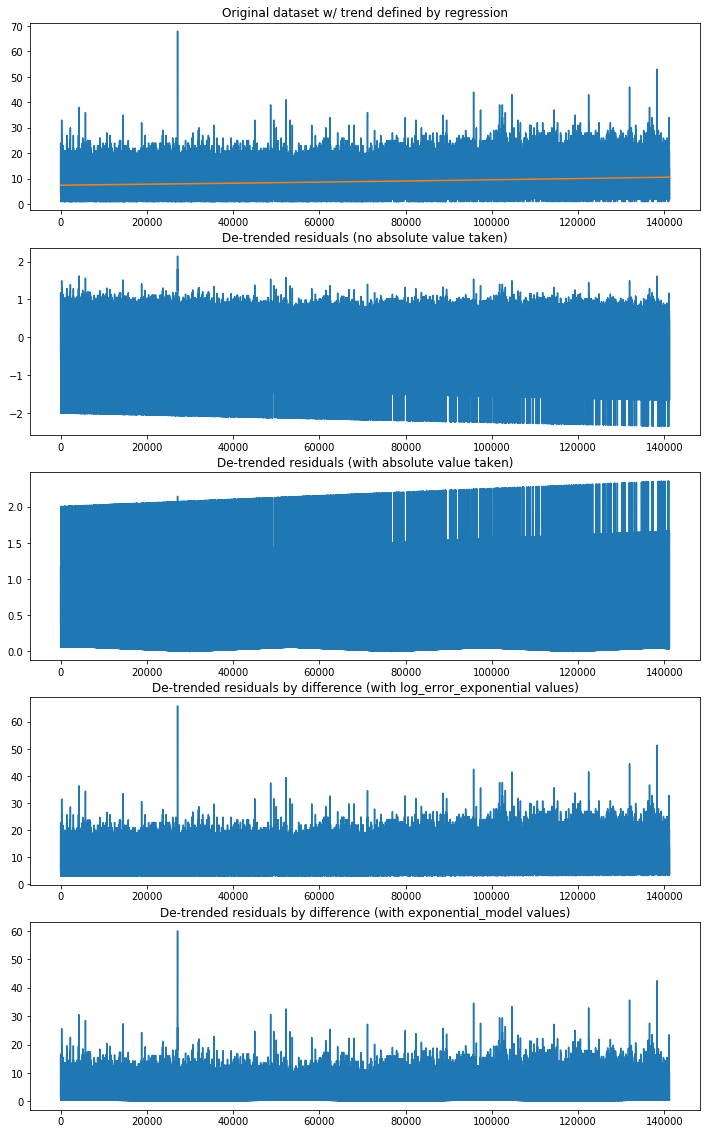

In [19]:
#Visualize the de-trending process
fig4, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 20))

ax1.title.set_text('Original dataset w/ trend defined by regression')
ax1.plot(exp_model_df.index, exp_model_df.incident_count) #original dataset
ax1.plot(exp_model_df.index, exp_model_df.exponential_model) #trend

ax2.title.set_text('De-trended residuals (no absolute value taken)')
ax2.plot(exp_model_df.index, exp_model_df.log_error_exponential)

ax3.title.set_text('De-trended residuals (with absolute value taken)')
ax3.plot(exp_model_df.index, np.abs(exp_model_df.log_error_exponential))

ax4.title.set_text('De-trended residuals by difference (with log_error_exponential values)')
ax4.plot(exp_model_df.index, (exp_model_df.incident_count - exp_model_df.log_error_exponential))

ax5.title.set_text('De-trended residuals by difference (with exponential_model values)')
ax5.plot(exp_model_df.index, np.abs(exp_model_df.incident_count - exp_model_df.exponential_model)) #use this (?)

Checking for stationarity again:

In [20]:
#Checking for the removal of stationarity from the dataset
print('Results of Dickey-Fuller Test:')
df_dickeyfuller = exp_model_df[['incident_hour', 'detrended_residuals']]
dftest = adfuller(df_dickeyfuller['detrended_residuals'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic             -25.895461
p-value                      0.000000
# Lags Used                 74.000000
# Observations Used     141118.000000
Critical Value (1%)         -3.430396
Critical Value (5%)         -2.861560
Critical Value (10%)        -2.566781
dtype: float64


### __Results:__
The test statistic is clearly far lower than any of the critical values, so we can reject the null hypothesis (thus inferring that the time series is now stationary).  Note that this was not the case prior to removing the trend.

## __Investigating Seasonality__

Why?

Looking at the plots above, one may suspect that the peaks and valleys occur with some periodicty.  This 'seasonality' in the data must be modeled (or removed) from our time series for accurate predictions.

Fourier Analysis (or more particularly the fast Fourier transform (FFT) algorithm, which is used to compute the Discrete Fourier Transform) can be used to determine and remove this seasonality.

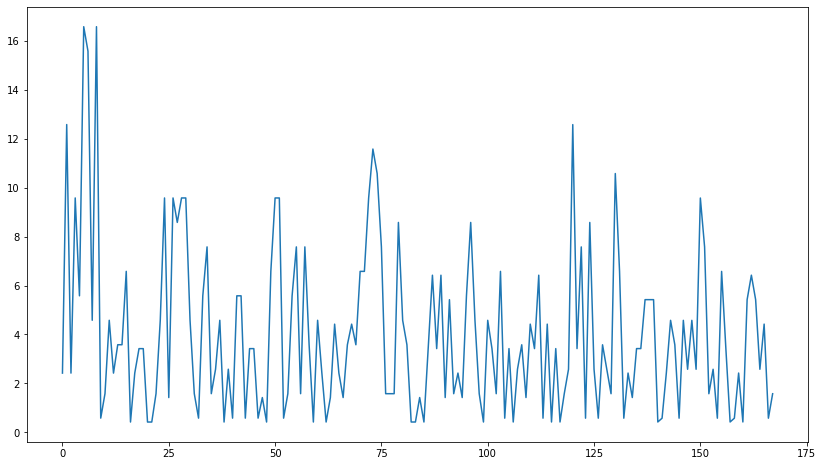

In [21]:
#Plot weekly data here to demonstrate seasonality
plt.figure(figsize=(14, 8))
plt.plot(np.abs(exp_model_df.detrended_residuals[:24*7]))

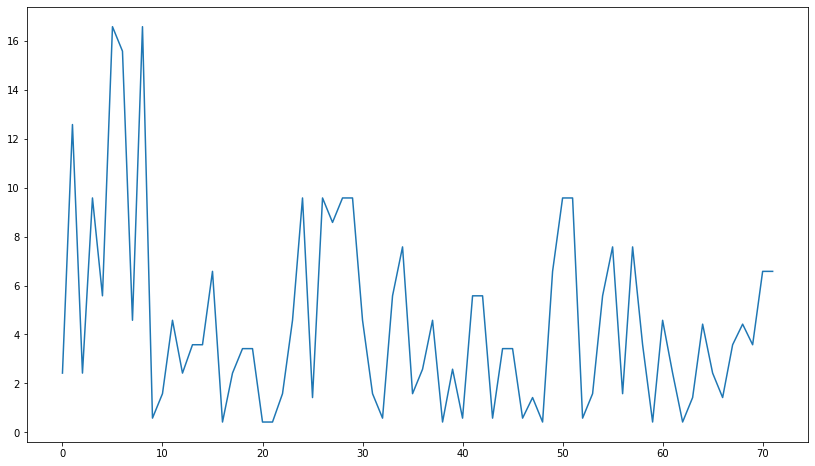

In [22]:
#Plotting calls over the first 72 hours of data to demonstrate seasonality
plt.figure(figsize=(14, 8))
plt.plot(np.abs(exp_model_df.detrended_residuals[:72]))

Because there are several distinct peaks, there is clear seasonality in the dataset occuring at the number of hours where a peak occurs on the x-axis.

## __Fourier Analysis__
Fourier analysis is used to formally determine the frequencies at which seasonalities are occuring in the dataset.  Looking at the data above, we can determine that seasonalities occur and that peaks typically occur between roughly 11am and 1pm, while troughs of activity occur roughly during the night hours.  We'll carry out the Fourier analysis to verify that these suspicions are present throughout the dataset though.

For more information on Fourier Transforms, take a look at [this video](https://www.youtube.com/watch?v=spUNpyF58BY).

In [23]:
exp_model_df.head()

,index,incident_hour,incident_count,constant,julian_datetime,exponential_model,log_error_exponential,detrended_residuals
0,0,2003-11-07 09:00:00,5,1.0,2.452951e+06,7.419940,-0.394733,-2.419940
1,1,2003-11-07 10:00:00,20,1.0,2.452951e+06,7.419958,0.991559,12.580042
2,2,2003-11-07 11:00:00,5,1.0,2.452951e+06,7.419977,-0.394738,-2.419977
3,3,2003-11-07 12:00:00,17,1.0,2.452951e+06,7.419995,0.829035,9.580005
4,4,2003-11-07 13:00:00,13,1.0,2.452951e+06,7.420014,0.560768,5.579986


### __Identifying the seasonality__

(-100, 20000)

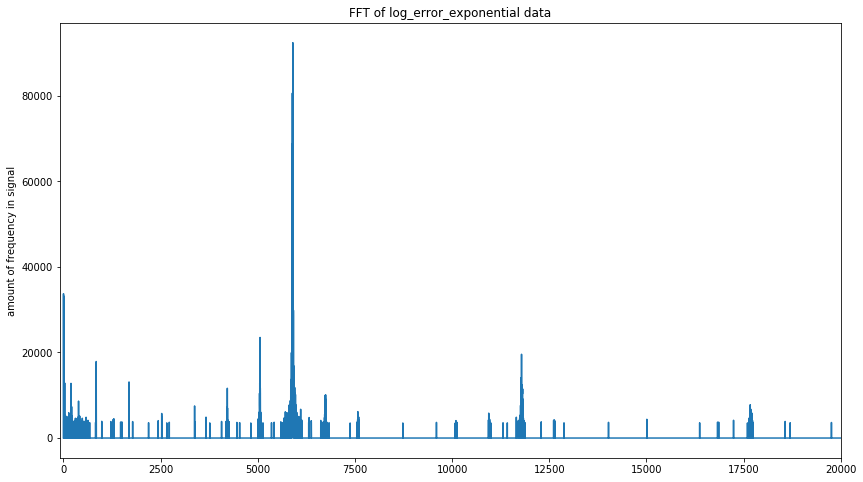

In [24]:
from scipy import fftpack

#Subtract the mean before computing the FFT to avoid representation of a large zero-frequency component
#Often times you'll get better results if you subtract the signal average before computing the FFT
fft_results = fftpack.fft(exp_model_df.detrended_residuals - exp_model_df.detrended_residuals.mean())

threshold = 3500
fft_results[np.abs(fft_results)<threshold] = 0 #Filter: set the values less than the peaks threshold to '0'

exp_model_df['noise'] = exp_model_df.detrended_residuals-fftpack.ifft(fft_results) #REMOVING SEASONALITY

#Plot results
plt.figure(figsize=(14, 8))
plt.plot(np.abs(fft_results));#1./1 --> 1 because that's the number of units per cycle I want plotted (1 unit = 1 hour)
plt.title('FFT of log_error_exponential data')
plt.ylabel('amount of frequency in signal')
plt.xlim([-100, 20000])

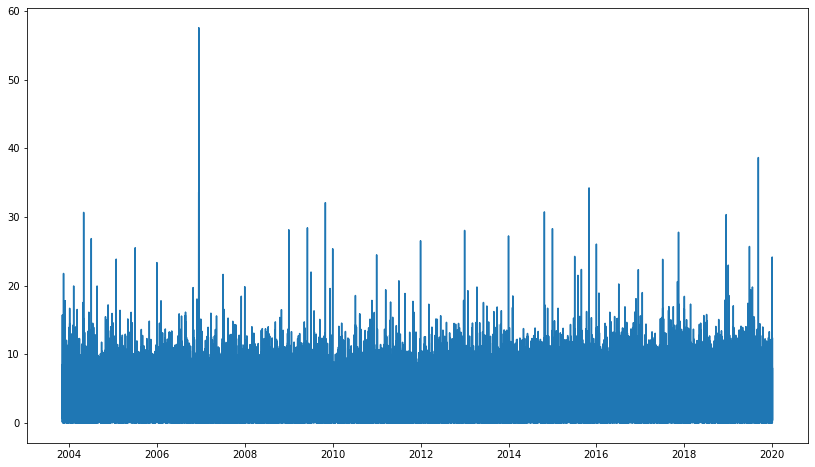

In [26]:
#Plot the resulting noise
plt.figure(figsize=(14, 8))
plt.plot(exp_model_df.incident_hour, np.abs(exp_model_df.noise))

In [27]:
exp_model_df.head()

,index,incident_hour,incident_count,constant,julian_datetime,exponential_model,log_error_exponential,detrended_residuals,noise
0,0,2003-11-07 09:00:00,5,1.0,2.452951e+06,7.419940,-0.394733,-2.419940,-6.728785+0.000000j
1,1,2003-11-07 10:00:00,20,1.0,2.452951e+06,7.419958,0.991559,12.580042,8.123497-0.000000j
2,2,2003-11-07 11:00:00,5,1.0,2.452951e+06,7.419977,-0.394738,-2.419977,-6.894411-0.000000j
3,3,2003-11-07 12:00:00,17,1.0,2.452951e+06,7.419995,0.829035,9.580005,5.232145-0.000000j
4,4,2003-11-07 13:00:00,13,1.0,2.452951e+06,7.420014,0.560768,5.579986,2.084920+0.000000j


In [59]:
#Checked the imaginary components of the complex values to see whether they're essentially equal to 0
temp = [np.imag(i) for i in exp_model_df.noise]
print('The largest imaginary value is: ', np.max(temp))

The largest imaginary value is:  3.3675153431130064e-15


In [73]:
#Create the label column
exp_model_df.noise = np.real(exp_model_df.noise) #gather real components from noise column
exp_model_df['label'] = exp_model_df['noise'].shift(-24)
exp_model_df.drop('index', axis=1, inplace=True)
exp_model_df.head()

,incident_hour,incident_count,constant,julian_datetime,exponential_model,log_error_exponential,detrended_residuals,noise,label
0,2003-11-07 09:00:00,5,1.0,2.452951e+06,7.419940,-0.394733,-2.419940,-6.728785,6.696136
1,2003-11-07 10:00:00,20,1.0,2.452951e+06,7.419958,0.991559,12.580042,8.123497,-5.293884
2,2003-11-07 11:00:00,5,1.0,2.452951e+06,7.419977,-0.394738,-2.419977,-6.894411,5.679681
3,2003-11-07 12:00:00,17,1.0,2.452951e+06,7.419995,0.829035,9.580005,5.232145,4.411278
4,2003-11-07 13:00:00,13,1.0,2.452951e+06,7.420014,0.560768,5.579986,2.084920,5.837476


In [86]:
temp_df = exp_model_df[['incident_hour', 'julian_datetime', 'label']][:365]
temp_df

,incident_hour,julian_datetime,label
0,2003-11-07 09:00:00,2.452951e+06,6.696136
1,2003-11-07 10:00:00,2.452951e+06,-5.293884
2,2003-11-07 11:00:00,2.452951e+06,5.679681
3,2003-11-07 12:00:00,2.452951e+06,4.411278
4,2003-11-07 13:00:00,2.452951e+06,5.837476
...,...,...,...
360,2003-11-22 10:00:00,2.452966e+06,-1.186250
361,2003-11-22 11:00:00,2.452966e+06,-3.572786
362,2003-11-22 12:00:00,2.452966e+06,6.909469
363,2003-11-22 13:00:00,2.452966e+06,-0.518262


### __Creating features to model the seasonality__
???

MSE:  13.011268473463334
R^2:  -0.016049740666679968
Sample of predicted values:  
 338    1.417686
339    1.417864
340    1.418042
341    1.418220
342    1.418399
343    1.418577
344    1.418755
345    1.418933
346    1.419111
347    1.419290
Name: predicted_value, dtype: float64


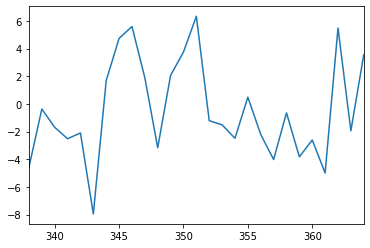

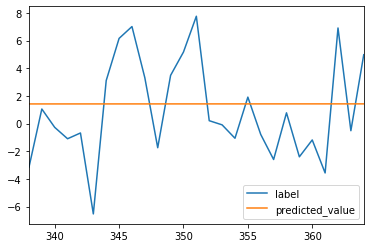

In [83]:
from datetime import timedelta
def run_regression(df, dependent, label):
    cut_datetime = df[dependent].max()-timedelta(hours=26) #24 hour lag plus 4 hours to predict

    train = df[df[dependent] < cut_datetime][['julian_datetime', label]].dropna(how='any') #train == data before cut_datetime
    test = df[df[dependent] >= cut_datetime][['julian_datetime', label]].dropna(how='any') #test == data after cut_datetime

    regress = sklearn.linear_model.LinearRegression().fit(
                                              X = train[['julian_datetime']],
                                              y = train[label])

    test['predicted_value'] = regress.predict(
                                              X = test[['julian_datetime']])

    #Plots
    (test[label] - test['predicted_value']).plot()
    test[[label, 'predicted_value']].plot()

    #Metrics
    print('MSE: ', sklearn.metrics.mean_squared_error(test[label], test['predicted_value']))
    print('R^2: ', sklearn.metrics.r2_score(test[label], test['predicted_value']))
    print('Sample of predicted values: ', '\n', test['predicted_value'][:10])
run_regression(exp_model_df, 'incident_hour', 'label')

### __Autocorrelation__

Autocorrelation is, "a measure of how similar a signal at different lags is to itself."

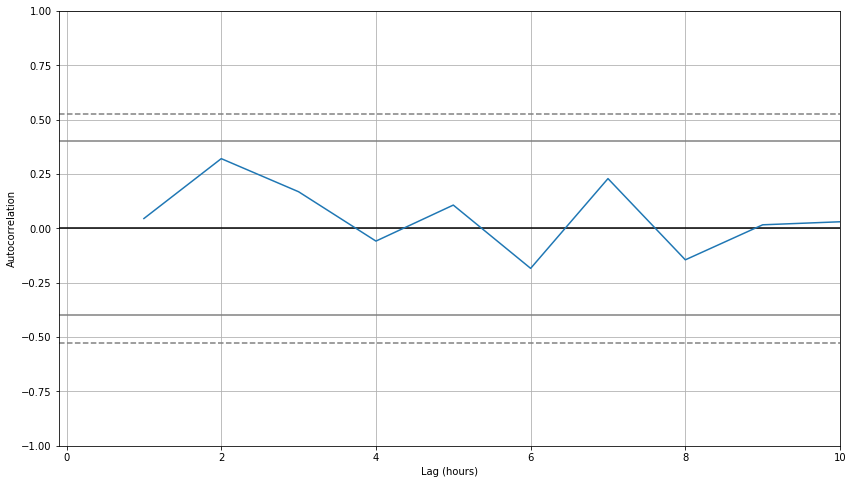

In [101]:
# Check autocorrelation to determine how far back in the data we should look when calculating a prediction
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(14, 8))
autocor = autocorrelation_plot(calls_grouped_hour['noise'][:24])
plt.xlabel('Lag (hours)')
plt.xlim(-0.1, 10)
# plt.ylim(-0.15, 0.2)
plt.axvline(365*24, color='green')

In [ ]:
period = 1
prediction_lag = period * 4